In [46]:
from face_processing import FaceDetector
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

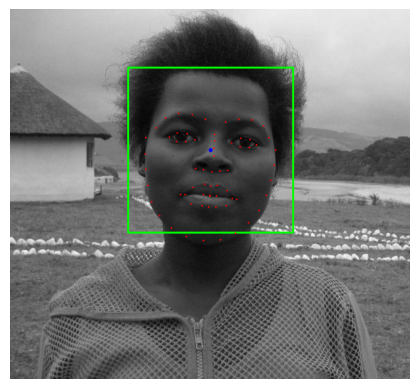

In [47]:
IMAGE_PATH = "test_images/helen1.jpg"

face_detector = FaceDetector()
img_rgb, _, face_centers, landmarks_all_faces = face_detector.detect(IMAGE_PATH)

face_detector.display(img_rgb)

In [51]:
class MaskHandler:
    def mask_points(self, img_path: str, landmarks: List[np.ndarray]) -> Tuple[np.ndarray, List[Dict[str, List[Tuple[int, int]]]]]:
        """
        selects specific facial landmarks and highlights them on the image

        in:
            img_path (str): path to the input image file
            landmarks (List[np.ndarray]): list of 68-point landmarks for each detected face

        out:
            img_rgb (np.ndarray): rgb image with selected landmark points highlighted
            selected_pts (List[Dict[str, List[Tuple[int, int]]]]): list of selected (x, y) points per face, organized by region
        """

        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img_read, cv2.COLOR_GRAY2RGB)

        idxs = {
            "left half": [17, 21, 30, 31, 48],
            "right half": [30, 22, 26, 54, 35],
            "nose": [21, 22, 30],
            "left eye": [36, 37, 38, 39, 40, 41],
            "right eye": [42, 43, 44, 45, 46, 47],
            "upper lip": [48, 49, 50, 51, 52, 53, 54, 60, 61, 62, 63, 64]
        }

        selected_pts = []

        for lm in landmarks:
            face_pts = {}
            for key, group in idxs.items():
                group_coordinates = [(int(lm[i][0]), int(lm[i][1])) for i in group]
                for pt in group_coordinates:
                    cv2.circle(img_rgb, pt, 3, (0, 255, 255), -1)
                face_pts[key] = group_coordinates
            selected_pts.append(face_pts)

        return img_rgb, selected_pts

    def build_mask(self, img_path: str, mask_pts: List[Dict[str, List[Tuple[int, int]]]]) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """
        builds masks for each face by filling selected facial regions (left half, right half, and upper lip)
        and excluding eye regions using convex hulls

        in:
            img_path (str): path to the original grayscale image
            mask_pts (List[Dict[str, List[Tuple[int, int]]]]): list of selected (x, y) coordinates per face to form convex hulls

        out:
            mask (List[np.ndarray]): grayscale masks with selected regions filled (255) and omitted regions (0)
            masked_img (List[np.ndarray]): grayscale images with the masks applied, keeping only the selected regions
        """

        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        masks = []
        masked_imgs = []

        for face in mask_pts:
            mask = np.zeros(img_read.shape, dtype=np.uint8)
            for key, group in face.items():
                polygon = np.array(group, dtype=np.int32)
                if key in ["left half", "right half", "upper lip", "nose"]:
                    cv2.fillPoly(mask, [polygon], color=255)
                else:
                    hull = cv2.convexHull(polygon)
                    cv2.fillPoly(mask, [hull], color=0)

            masked_img = cv2.bitwise_and(img_read, mask)
            masked_img = cv2.cvtColor(masked_img, cv2.COLOR_GRAY2RGB)

            masks.append(mask)
            masked_imgs.append(masked_img)

        return masks, masked_imgs

    def display(self, masked_img: np.ndarray) -> None:
        """
        displays an image

        in:
            masked_img (np.ndarray): grayscale image with the applied mask.
        """
        plt.imshow(masked_img)
        plt.axis('off')
        plt.show()

    def get_intensity_probability_maps(self, img_path: str, masks: List[np.ndarray]) -> List[np.ndarray]:
        """
        gets probablity maps for each of the faces provided via the mask_pts.

        in:
            img_path (str): path to input image file
            mask_pts (List[np.ndarray]): list of masks, one for each face.

        out:
            prob_maps (List[np.ndarray]): Pixel intensity histograms per face
        """
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        prob_maps = []

        for mask in masks:

            face_pixels = img_gray[mask == 255]
            if len(face_pixels) == 0:
                prob_maps.append(np.zeros(256))
                continue

            hist = cv2.calcHist([face_pixels], [0], None, [256], [0, 256])
            prob_map = hist / hist.sum()
            prob_maps.append(prob_map.flatten())

        return prob_maps

    def visualize_probability_histograms(self, prob_maps) -> None:
        """
        Visualize only the probability histograms/maps returned from get_intensity_probability_maps.

        in:
            prob_maps (List[np.ndarray]): List of probability maps for each mask
        """
        import matplotlib.pyplot as plt
        import numpy as np

        # Create a figure with subplots for each probability map
        n_maps = len(prob_maps)
        fig, axes = plt.subplots(n_maps, 1, figsize=(10, 3 * n_maps))

        # Handle the case of a single histogram
        if n_maps == 1:
            axes = [axes]

        # Plot each probability histogram
        for i, prob_map in enumerate(prob_maps):
            x = np.arange(256)
            axes[i].bar(x, prob_map, color='blue', alpha=0.7)
            axes[i].set_title(f'Probability Distribution - Mask {i+1}')
            axes[i].set_xlabel('Pixel Intensity')
            axes[i].set_ylabel('Probability')

            # Add some stats to the plot
            non_zero = prob_map[prob_map > 0]
            if len(non_zero) > 0:
                max_prob = np.max(prob_map)
                mean_intensity = np.sum(x * prob_map) / np.sum(prob_map)
                axes[i].text(0.02, 0.95, f'Max probability: {max_prob:.4f}\nMean intensity: {mean_intensity:.1f}',
                            transform=axes[i].transAxes, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()

    def display_intensity_probablity_map(self, img_path: str, prob_map: np.ndarray) -> None:
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
        colormap = plt.get_cmap('plasma')

        non_zero_mask = prob_map > 0
        if np.any(non_zero_mask):
            non_zero_values = prob_map[non_zero_mask]

            min_prob = np.min(non_zero_values)
            max_prob = np.max(non_zero_values)

            enhanced_prob = np.zeros_like(prob_map)

            # Apply stretching to non-zero values only
            if max_prob > min_prob:
                # Linear stretching from 0 to 1
                enhanced_prob[non_zero_mask] = (prob_map[non_zero_mask] - min_prob) / (max_prob - min_prob)
            else:
                # If only one non-zero value exists
                enhanced_prob[non_zero_mask] = 1.0
        else:
            # Fallback if no non-zero values
            enhanced_prob = prob_map

        for intensity in range(256):
            if prob_map[intensity] > 0:
                prob = enhanced_prob[intensity]
                rgba = colormap(float(prob))

                r, g, b = [int(255 * c) for c in rgba[:3]]
                img_rgb[img_gray == intensity] = [r, g, b]


        plt.imshow(img_rgb)
        plt.axis('off')


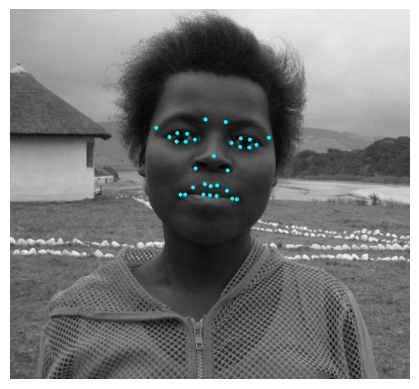

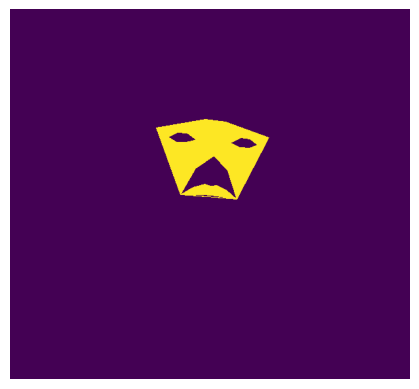

In [52]:
mask_handler = MaskHandler()

# Mask the points in the image using the landmarks from the FaceDetector
masked_img, selected_pts = mask_handler.mask_points(IMAGE_PATH, landmarks_all_faces)

# Display the result after masking the points
mask_handler.display(masked_img)

# Build the mask and display it
masks, masked_imgs = mask_handler.build_mask(IMAGE_PATH, selected_pts)
mask_handler.display(masks[0])

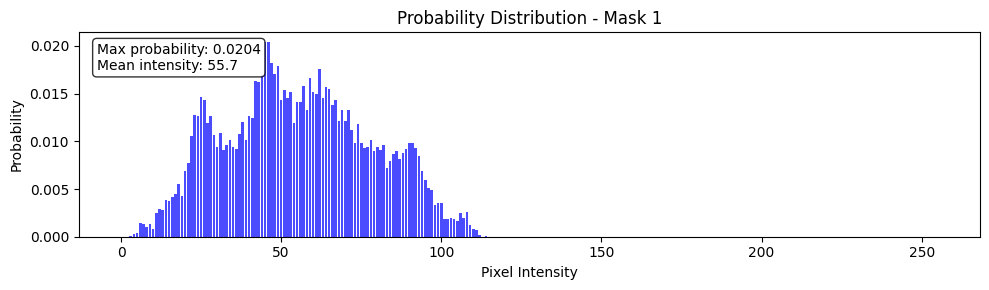

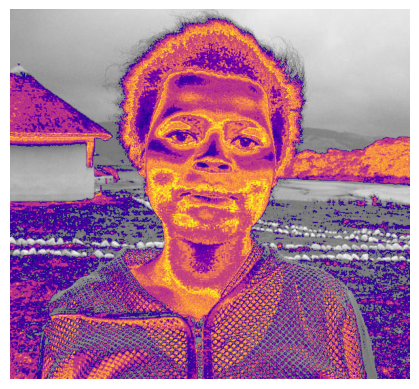

In [53]:
prob_maps = mask_handler.get_intensity_probability_maps(IMAGE_PATH, masks)

mask_handler.visualize_probability_histograms(prob_maps)

mask_handler.display_intensity_probablity_map(IMAGE_PATH, prob_maps[0])